In [2]:
import pandas as pd
import numpy as np
from snownlp import SnowNLP
import jieba
import pyLDAvis.gensim
import wordcloud
import os, codecs
import jieba.posseg as pseg
import matplotlib.pyplot as plt
from collections import Counter
from pylab import mpl
from gensim import corpora,models
import seaborn as sns

In [3]:
df=pd.read_csv('F:/在线评论数据2好评.csv')
df1= df['text']

In [4]:
#查询重复值
df1.duplicated().value_counts() 
#处理重复值
df2= df1.drop_duplicates()
df2.duplicated().value_counts() 
#去除短句，保留长度大于5的数据
df3 = df2[df2.str.len()>5]
df3 = df3.reset_index(drop=True)
data =df3.tolist()

In [5]:
def load_stopword():
    '''
    加载停用词表
    :return: 返回停用词的列表
    '''
    f_stop = open('F://stopWord.txt','r',encoding='UTF-8')
    sw = [line.strip() for line in f_stop]
    f_stop.close()
    sw.append('\n')
    return sw

In [6]:
stopwords = load_stopword()
#自定义字典
jieba.load_userdict("F://dict.txt")
text_list = []
cloud_text = ''
c = Counter()
for i in range(len(df3)):
    seg_list = jieba.posseg.cut(df3[i])
    mytext_list=[]
    for x in seg_list:
        if len(x.word)>1 and x.word != '\r\n' and x.word not in stopwords :#  and x.flag =='n':
            c[x.word] += 1
            mytext_list.append(x.word.replace(" ",""))
    text_list.append(mytext_list)
    cloud_text+=",".join(mytext_list)
print('词频度统计结果')
for (k,v) in c.most_common(50):
    print('{}:{}'.format(k,v))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\59433\AppData\Local\Temp\jieba.cache
Loading model cost 0.779 seconds.
Prefix dict has been built successfully.


词频度统计结果
不错:1987
值得:1060
景色:732
建筑:721
感觉:688
适合:676
庄园:660
门票:549
孩子:508
方便:493
特别:485
特色:471
文化:455
喜欢:427
风景:401
环境:382
小时:381
游玩:354
拍照:346
历史:345
博物馆:340
时间:320
俄罗斯:313
城堡:302
体验:297
推荐:296
参观:290
看到:290
了解:286
开心:282
很漂亮:277
漂亮:272
周庄:265
风情:245
表演:245
游客:243
生活:224
伏尔加庄园:214
位于:210
好看:209
平遥:207
需要:205
建议:204
旅游:204
好玩:203
菊花:202
演出:198
一起:198
沈万三:198
觉得:196


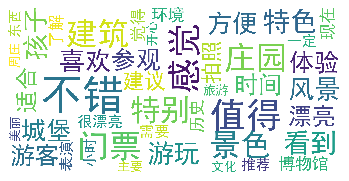

In [7]:
#创建词云
font = "C:\\Windows\\Fonts\\simhei.TTF"#词云的中文字体所在路径
wc = wordcloud.WordCloud(
    scale = 7,
    background_color="white", #背景颜色
    #max_words=200, #显示最大词数
    font_path=font,
    min_font_size=15,
    max_font_size=50, 
    width=400  #图幅宽度
    )
wc.generate(cloud_text)

plt.imshow(wc)
plt.axis("off")
plt.show()

In [8]:
# 主题分析
text_dict = corpora.Dictionary(text_list) # 创建语料的词语词典，每个单独的词语都会被赋予一个索引
text_corpus = [text_dict.doc2bow(i) for i in text_list] # 使用上面的词典，将转换文档列表（语料）变成 DT 矩阵
tfidf = models.TfidfModel(text_corpus)
corpus_tfidf = tfidf[text_corpus]

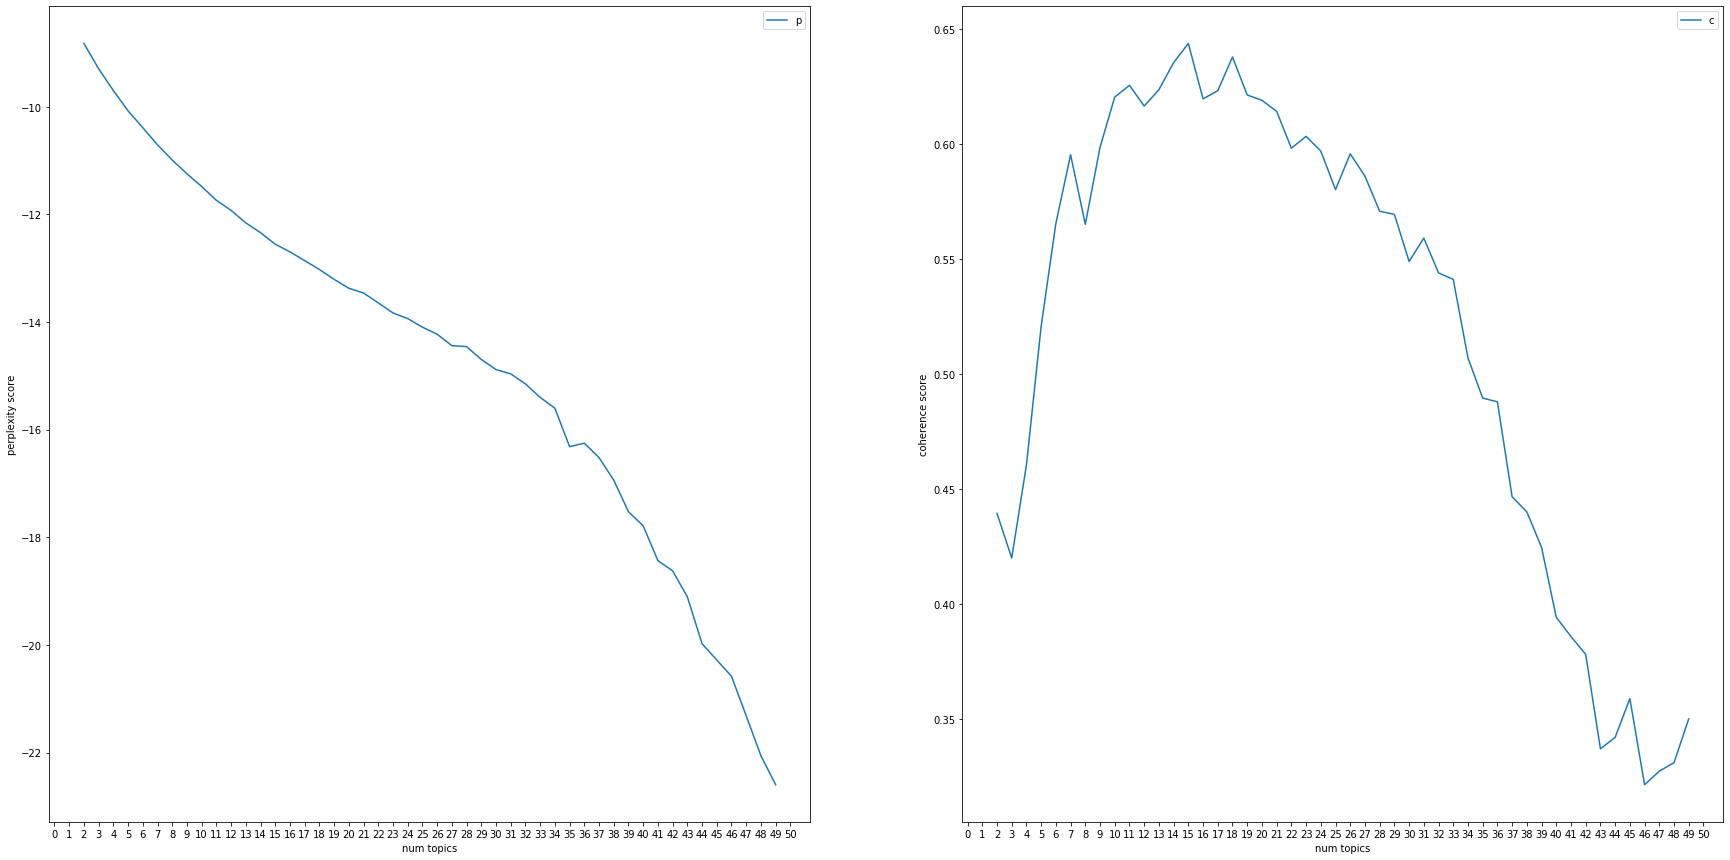

In [14]:
#困惑度 一致度
x_list = []
y_plist =[]
y_clist =[] 
for i in range(2,50):
    text_lda = models.LdaModel(corpus_tfidf,num_topics = i,id2word =text_dict ) # LDA模型训练
    perplexity = text_lda.log_perplexity(corpus_tfidf)
    cv_tmp = models.CoherenceModel(model=text_lda,texts=text_list, dictionary=text_dict, coherence='c_v')
    x_list.append(i)
    y_plist.append(perplexity)
    y_clist.append(cv_tmp.get_coherence())
    
plt.figure(figsize=(30,15))    
plt.subplot(1,2,1)
plt.plot(x_list,y_plist)
plt.xticks(np.linspace(0, 50, 51))
plt.xlabel('num topics')
plt.ylabel('perplexity score')
plt.legend(('perplexity_values'), loc='best')

plt.subplot(1,2,2)
plt.plot(x_list,y_clist)
plt.xticks(np.linspace(0, 50, 51))
plt.xlabel('num topics')
plt.ylabel('coherence score')
plt.legend(('coherence_values'), loc='best')

plt.show()

In [9]:
lda = models.LdaModel(text_corpus,num_topics =34,id2word =text_dict ) # LDA模型训练
for i in range(34):
    print('topic' + str(i))
    print(lda.print_topic(i)) # 输出每个主题

topic0
0.080*"俄罗斯" + 0.061*"葡萄" + 0.016*"好吃" + 0.016*"值得" + 0.012*"市区" + 0.012*"30" + 0.010*"很漂亮" + 0.009*"沈万三" + 0.009*"特别" + 0.009*"建议"
topic1
0.017*"古城" + 0.013*"春天" + 0.013*"知识" + 0.012*"名人" + 0.011*"婚纱" + 0.010*"博物馆" + 0.009*"建筑" + 0.008*"有待" + 0.007*"记忆" + 0.007*"牌坊"
topic2
0.031*"好玩" + 0.029*"景色" + 0.013*"旅行" + 0.012*"高兴" + 0.012*"值得" + 0.011*"优美" + 0.010*"有名" + 0.010*"环境" + 0.010*"好多" + 0.010*"实惠"
topic3
0.118*"城堡" + 0.024*"古堡" + 0.015*"方便" + 0.015*"草坪" + 0.012*"欧式建筑" + 0.012*"打车" + 0.011*"交通" + 0.010*"管理" + 0.009*"盛开" + 0.009*"早点"
topic4
0.029*"交通" + 0.022*"方便" + 0.011*"观赏" + 0.010*"春节" + 0.010*"梨花" + 0.009*"淡季" + 0.009*"便利" + 0.009*"住宿" + 0.008*"不错" + 0.008*"值得"
topic5
0.025*"想象" + 0.025*"还行" + 0.021*"不错" + 0.020*"周末" + 0.016*"感觉" + 0.016*"小贵" + 0.013*"门票" + 0.012*"丰富" + 0.010*"联票" + 0.010*"停车场"
topic6
0.015*"场地" + 0.013*"精美" + 0.012*"一个多" + 0.012*"古建筑" + 0.011*"趣味" + 0.011*"性价比" + 0.009*"呵呵" + 0.009*"牌坊" + 0.009*"逛逛" + 0.009*"当天"
topic7
0.021*"不错" + 0.015*"院落" + 0.015*"季节" +

In [11]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

# Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
# Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

# Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [12]:
#文档中贡献百分比最高的主题
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=text_corpus, texts=data)# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']# Show
df_dominant_topic.head(10)
#df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,26.0,0.9704,"文化, 园林, 占地面积, 大院, 位于, 宅院, 主楼, 房子, 建筑, 院子",馆内珍藏有1220余件苗族文物和350余张有代表性的图片、画像、书籍，从苗族历史、生产、生活...
1,1,26.0,0.7771,"文化, 园林, 占地面积, 大院, 位于, 宅院, 主楼, 房子, 建筑, 院子",去西江千户苗寨必定要去看看这个博物馆，位于寨子中心区，无需门票。馆内珍藏有1220余件苗族文...
2,2,0.0,0.6935,"俄罗斯, 葡萄, 好吃, 值得, 市区, 30, 很漂亮, 沈万三, 特别, 建议",很好的景点，就是人太多了，导致住宿价格搞得离谱，建议不要七八月份来。餐饮的价格倒是管理的不错...
3,3,7.0,0.7087,"不错, 院落, 季节, 人不多, 应该, 合适, 感觉, 拍照, 走走, 特别",苗族的习俗有一部分和我们汉族人一样里面是免费参观。馆里分的清清楚楚每个房间的介绍。有长桌宴，...
4,4,9.0,0.6184,"风格, 适合, 好多, 出游, 很漂亮, 安静, 值得, 自驾, 拍照, 观光",不错，建议都来玩下，这里的价格很地道，比国内其他景点好多了，特别是比临近的黄果树瀑布好多了，...
5,5,14.0,0.8613,"文化, &#, 了解, 知识, 方便, 博物馆, 历史, 值得, 买票, 小镇",苗寨的历史，苗寨的文化，苗寨的习俗。
6,6,26.0,0.4401,"文化, 园林, 占地面积, 大院, 位于, 宅院, 主楼, 房子, 建筑, 院子",西江苗族是黔东南苗族的重要组成部分之一，现主要居住的是苗族的“西”氏族。作为全世界最大的苗寨...
7,7,8.0,0.7337,"建筑, 历史, 了解, 保存, 值得, 规模, 家族, 文化, 中国, 完整",这个博物馆还是值得一看的，全面了解苗族的历史人文，规模还是比较小的
8,8,31.0,0.7573,"不错, 园区, 很好, 环境, 地下, 走走, 度假, 休闲, 景色, 介绍",免费。。人多。介绍还是很详细。
9,9,2.0,0.9113,"好玩, 景色, 旅行, 高兴, 值得, 优美, 有名, 环境, 好多, 实惠",可以啊这个地方，挺有点特色，然后也很客气热情，不像那些评论说的那么可怕，我是以我几乎走遍中国...


# 情感分析

In [15]:
df_dominant_topic['Topic'] = None

df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([2,9,11,12,16,21,31])] = '自然环境优美'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([5,7,15,19,20,23,24,25])] = '游玩感受良好'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([10,17,29,30])] = '老少皆宜'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([1,8,14,26,28,32])] = '历史底蕴丰厚'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([0,3,13,22,27])] = '多元特色文化'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([4,18,33])] = '服务完善'
df_dominant_topic.fillna('others',inplace = True)

df_dominant_topic.fillna('others',inplace = True)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWit

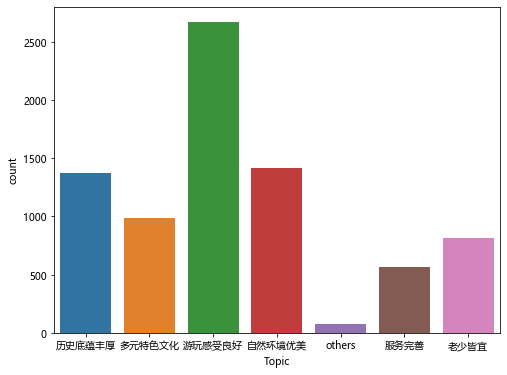

In [53]:
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.figure(figsize=(8,6)) 
sns.countplot(df_dominant_topic['Topic'])

In [17]:
Attitude = []    
for i, v in df_dominant_topic['Text'].iteritems():
    s = SnowNLP(v)
    Attitude.append(s.sentiments)
df_dominant_topic['Attitude'] = Attitude

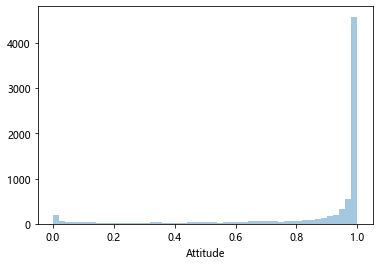

In [18]:
#所有主题的情感倾向分布情况
sns.distplot(df_dominant_topic['Attitude'],kde = False)

In [26]:
#对该主题下情感倾向大于0.8的评论进行分析
df_dominant_topic[df_dominant_topic['Attitude']<0.05]['Text']

156       集古城古镇于大全，超过了我原来心目中的丽江等，划过流淌的碧水，穿过古城的昨日。千万不要节假日来
163     又见平遥说的是一百多年前赵家镖局200多人为了义字不畏艰辛，不畏牺牲，远赴沙俄，最终把王家血...
225     平遥的强烈推荐之一，周五当天请客栈老板帮忙订票，被告知只有周六下午和晚上9点的了，老板不慌不...
228     这场演出《又见平遥》，是网络上传的比较火的，是平遥的一张名片，价钱真是小贵，正常售票价钱，2...
307     非常开心的平遥周末游。听同事说起又见平遥演出，非常想去看，这么说吧，去平遥就是去看《又见平遥...
309     演出前到一公共厕所去碰头拿票，有点像特务接头！不能换一个没有味的的地方么？因为是走着看，所以...
336     第二次看这个演出，这次是带家人一起去的，淡季在携程定是236元一张 ，在平遥古城街道上的代售...
339     去古城买更方便价格一样，住的酒店客栈基本都有帮买的，而且直接就拿到了。网上买的还得去取票，麻...
374     中华回乡文化园成人参观门票：60元；月上贺兰演出票：168元\n    1.景区开放时间：夏...
425     首先要给大家说下，在南门广场坐车大概得一个半左右小时能到，网上说的50分钟肯定是到不了的，南...
426     严重不满景区做法：\n1、大门口免费照相，照相时说的免费2张，取相片时收费20元每张。\n2...
430     丽江游玩4-5天，足够玩遍丽江。第一天玉龙雪山游玩，包车200元，准备好冲锋衣，羽绒服。穿厚...
437     束河古镇特别值得过去住几天，比丽江古城清净多了，没有那么浓的商业气息。每天清晨时分，镇子里安...
440                               比丽江清净，但丽江的今天也许就是束河的明天……
453     到丽江去的束河古镇，本来孤陋寡闻，甚至不知道它的名字，同行的游客说它比丽江古镇要赞才入的。后...
474     不知介绍中为何要提到门票，我受其误导四处找售票处找不到，问询路边游客，被人笑话，古镇既没有围...
508     古镇里三眼井有十多处，造型都差不多，为正方形，连在一起，说是第一口井饮用，第二口洗菜，第三口...
509     纳西人的地界

In [30]:
#情况1
df.iloc[440,]['text']

'束河古镇特别值得过去住几天，比丽江古城清净多了，没有那么浓的商业气息。每天清晨时分，镇子里安静的让人不敢大声说话呢！我喜欢，下次还会再来！'

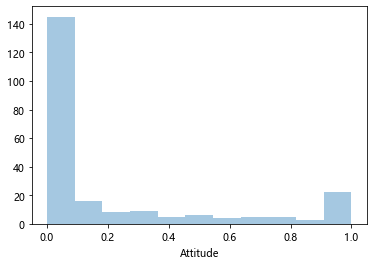

In [30]:
#某个主题的情感倾向分布情况-性价比低
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='性价比低']['Attitude'],kde = False)

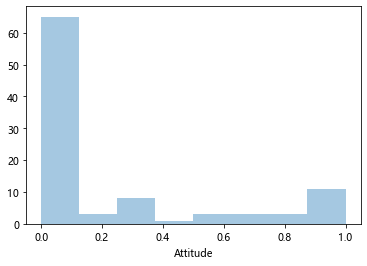

In [31]:
#某个主题的情感倾向分布情况-景区及周边管理秩序混乱
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='景区及周边管理秩序混乱']['Attitude'],kde = False)

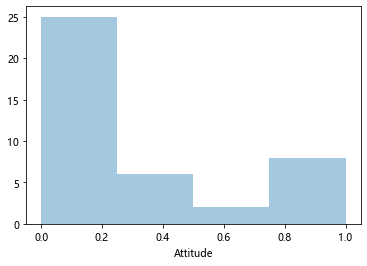

In [32]:
#某个主题的情感倾向分布情况-部分工作人员服务差
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='部分工作人员服务差']['Attitude'],kde = False)

In [33]:
#情况2
a = SnowNLP('束河古镇特别值得过去住几天，比丽江古城清净多了，没有那么浓的商业气息。每天清晨时分，镇子里安静的让人不敢大声说话呢！我喜欢，下次还会再来')
a.sentiments

0.000672019386475986

# 统计分析

In [34]:
df_gender_fans_sta = pd.merge(df,df_dominant_topic,left_on='text',right_on='Text',how='inner')[['gender','粉丝','text','Topic']]

In [35]:
df_gender_fans_sta.dropna(inplace = True)

In [36]:
df_gender_fans_sta.groupby(['Topic','gender']).count().T

Topic  others      历史底蕴丰厚      多元特色文化        服务完善      游玩感受良好         老少皆宜  \
gender female male female male female male female male female  male female   
粉丝         47   32    650  751    533  511    271  311   1435  1416    468   
text       47   32    650  751    533  511    271  311   1435  1416    468   

Topic       自然环境优美       
gender male female male  
粉丝      394    743  771  
text    394    743  771

In [37]:
index = df_gender_fans_sta['Topic'].value_counts(normalize = True, dropna = False).index
statistics = df_gender_fans_sta.groupby(['Topic','gender']).text.count().T.values.tolist()

female_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='female'].shape[0]   #男游客评论人数
male_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='male'].shape[0]       #女游客评论人数

a,b = [],[]
for i in range(len(statistics)):                                                      #标准化
    if i%2 ==0:
        a.append(statistics[i]/female_count)
    else:
        b.append(statistics[i]/male_count)
for i in range(len(a)):
    a[i],b[i] = a[i]/(a[i]+b[i]),b[i]/(a[i]+b[i])

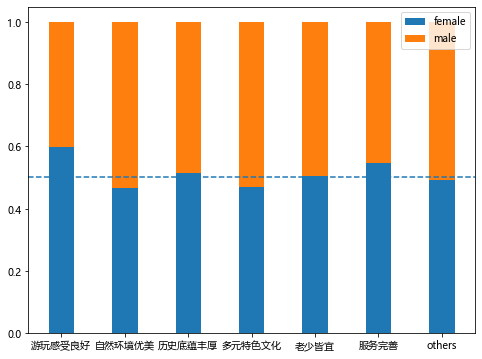

In [49]:
plt.figure(figsize=(8,6))
plt.bar(index, a, width=0.4, label='female')
plt.bar(index, b, width=0.4, bottom=a, label= 'male')
plt.axhline(y = 0.5,ls ='--')
plt.legend(loc=1)
plt.show()

In [44]:
fans_sta = df_gender_fans_sta[df_gender_fans_sta['粉丝']>500].groupby('Topic').text.count()
fans_sta

Topic
others      1
历史底蕴丰厚    113
多元特色文化     43
服务完善       33
游玩感受良好     78
老少皆宜       34
自然环境优美     61
Name: text, dtype: int64

<BarContainer object of 7 artists>

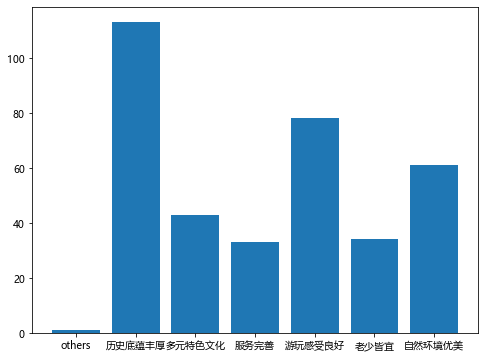

In [50]:
plt.figure(figsize=(8,6))
plt.bar(fans_sta.index,fans_sta.tolist())